# Physical model representation using Machine-Learning 

Gammapy allows to implement custom models.
Physical models can be very time consumming to evaluate.
However a simpler representation of the models can be approximated using machine-learning.
Here we show a minimal example where a Naima model is replaced by a surrogate model trained with scikit-learn.

In [1]:
import time   

import numpy as np
from dataclasses import dataclass

import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord

import naima
from gammapy.irf import load_irf_dict_from_file
from gammapy.maps import MapAxis, WcsGeom
from gammapy.data import Observation, observatory_locations
from gammapy.datasets import MapDataset
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    SpectralModel, SkyModel, SPECTRAL_MODEL_REGISTRY,
    PointSpatialModel, FoVBackgroundModel, NaimaSpectralModel
)
from gammapy.modeling import  Parameter, Parameters
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor


/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/naima/version.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


### Define TRUE model with Naima

Mirror the Gammapy Naima example (IC).

See : https://docs.gammapy.org/dev/user-guide/model-gallery/spectral/plot_naima.html

In [2]:
@dataclass
class ICConfig:
    distance = 1.5 * u.kpc
    e0      = 10.0 * u.TeV
    Eemin   = 100.0 * u.GeV
    seeds   = ["CMB", ["FIR", 26.5 * u.K, 0.415 * u.eV / u.cm**3]]

CFG = ICConfig()

def make_naima_spectral_model(amplitude_eV_inv: float, alpha: float, e_cutoff_TeV: float, use_cache=False):
    pdist = naima.models.ExponentialCutoffPowerLaw(
        amplitude_eV_inv / u.eV, CFG.e0, alpha, e_cutoff_TeV * u.TeV
    )
    rad = naima.radiative.InverseCompton(pdist, seed_photon_fields=CFG.seeds, Eemin=CFG.Eemin)
    model = NaimaSpectralModel(radiative_model=rad, distance=CFG.distance, use_cache=use_cache)
    model.e_0.frozen=True
    model.beta.frozen=True
    model.amplitude.min=1e28
    model.amplitude.max=2e32
    model.alpha.min=1.5
    model.alpha.max=4
    model.e_cutoff.min=10**0.5
    model.e_cutoff.max=10**2.2
    return model


Set TRUE parameters for the simulation (ECPL electrons for IC)


In [3]:
TRUE = dict(amplitude=3e30 / u.eV, alpha=3.0, e_cutoff=30.0 * u.TeV)

### Simulated dataset

See: https://docs.gammapy.org/2.0/tutorials/analysis-3d/simulate_3d.html

Define energy axes

In [4]:
energy_reco = MapAxis.from_edges(np.logspace(-1., 2.0, 30), unit="TeV", name="energy", interp="log")
energy_true = MapAxis.from_edges(np.logspace(-1.2, 2.2, 35), unit="TeV", name="energy_true", interp="log")


Define sky geometry centered on the source

In [5]:
src_pos = SkyCoord(83.63, 22.01, unit="deg", frame="icrs")  # near the Crab
geom = WcsGeom.create(skydir=src_pos, width=(4, 4), binsz=0.05, frame="icrs", axes=[energy_reco])

Create observation from CTA 1DC  IRFs (shipped with Gammapy tutorials)


In [6]:
irfs = load_irf_dict_from_file("$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits")
obs = Observation.create(pointing=src_pos, livetime=50.0 * u.hr, irfs=irfs)


Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
/Users/qremy/Work/GitHub/gammapy/gammapy/data/observations.py:303: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


Reduce to a MapDataset and define safe mask (see https://docs.gammapy.org/2.0/tutorials/details/makers.html)

In [7]:
empty = MapDataset.create(geom=geom, energy_axis_true=energy_true, name="sim3d") 
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
dataset = maker.run(empty, obs)                                                 
safe = SafeMaskMaker(methods=["aeff-default"])
dataset = safe.run(dataset, obs)

No default upper safe energy threshold defined for obs 0
No default lower safe energy threshold defined for obs 0


Compose the TRUE sky model (spectral ⊗ spatial) + a FoV background component

In [8]:
true_spec = make_naima_spectral_model(TRUE["amplitude"].to_value(1/u.eV), TRUE["alpha"], TRUE["e_cutoff"].to_value(u.TeV))  
true_spatial = PointSpatialModel(lon_0=src_pos.ra, lat_0=src_pos.dec, frame="icrs")
true_source = SkyModel(spectral_model=true_spec, spatial_model=true_spatial, name="source")

bkg = FoVBackgroundModel(dataset_name=dataset.name)  # simple FoV background model with power-law spectral correction
dataset.models = [true_source, bkg]

Poisson-sample counts for source + background


In [9]:
dataset.fake(random_state=0)  # fills dataset.counts with dataset.npred() and add Poisson fluctuations                     


## Train a Surrogate model

Train a surrogate model : (log10 E, log10 A, alpha, log10 Ecut) -> log10 dnde


Training ranges (physically motivated by the Naima/Gammapy gallery example)


In [10]:
bounds = {
    "log10_amp": (28.0, 32.0),   # amplitude [1/eV]
    "alpha":     (1.5, 4.0),
    "log10_ec":  (0.5, 2.2),     # e_cutoff [TeV]
}

Training energies = true energy axis centers upsampled


In [11]:
E_true = energy_true.center.to(u.TeV)
#E_true_train = energy_true.upsample(factor=1).center.to(u.TeV)  # increase if needed
E_true_train = energy_true.upsample(factor=5).center.to(u.TeV)


Generate samples by evaluating the Naima model


In [12]:
def sample_params(n, rng):
    p = np.zeros((n, 3))
    p[:, 0] = rng.uniform(*bounds["log10_amp"], size=n)
    p[:, 1] = rng.uniform(*bounds["alpha"],     size=n)
    p[:, 2] = rng.uniform(*bounds["log10_ec"],  size=n)
    return p

rng = np.random.default_rng(0)
#P = sample_params(1000, rng)  # increase if needed
P = sample_params(2000, rng)


Create the feature matrix per energy : (log10 E, log10 A, alpha, log10 Ecut)


In [13]:
X_list, y_list = [], []
for logA, alpha, logEc in P:
    A = 10**logA
    Ec = 10**logEc
    m = make_naima_spectral_model(A, alpha, Ec)
    dnde = m(E_true_train).to("1/(cm2 s TeV)")  # Quantity                               
    logE = np.log10(E_true_train.value)
    X = np.column_stack([logE,
                         np.full_like(logE, logA),
                         np.full_like(logE, alpha),
                         np.full_like(logE, logEc)])
    y = np.log10(dnde.value)
    X_list.append(X); y_list.append(y)

X = np.vstack(X_list); y = np.concatenate(y_list)

Train a model using `sklearn.ensemble.GradientBoostingRegressor`

See: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html


In [14]:
%%time
surrogate = Pipeline([
    ("scaler", StandardScaler()),
    ("gbr", GradientBoostingRegressor(
        n_estimators=1500,
        max_depth=6,
        learning_rate=0.02,
        min_samples_leaf=100,
        subsample=1.0,
        random_state=0,
        tol=1e-5,
    )),
])    

surrogate.fit(X, y)
rmse = np.sqrt(np.mean((surrogate.predict(X) - y)**2))
print(f"[surrogate] train RMSE (log10 dnde): {rmse:.3f}")



[surrogate] train RMSE (log10 dnde): 0.049
CPU times: user 6min 14s, sys: 4.79 s, total: 6min 19s
Wall time: 6min 20s


## Wrap the surrogate model as a custom Gammapy SpectralModel


In [15]:
class NaimaSurrogateSpectralModel(SpectralModel):
    tag = ["NaimaSurrogateSpectralModel", "naima-surrogate"]
    _out_unit = u.Unit("1 / (cm2 s TeV)")
    
    amplitude = Parameter("amplitude", 3e31, unit="1 / eV", min=1e28, max=1e32)
    alpha = Parameter("alpha", 2.0, min=1.5, max=4.0)
    e_cutoff = Parameter("e_cutoff", 40, unit="TeV", min=10**0.5, max=10**2.2)

    def __init__(self, surrogate_pipeline, **kwargs):
        super().__init__(**kwargs)
        self._pipe = surrogate_pipeline

    def evaluate(self, energy, amplitude, alpha, e_cutoff):
        # Energies
        energy = u.Quantity(energy).to(u.TeV)
        E_shape = energy.shape
        E = energy.reshape(-1)                     # (N,)
        logE = np.log10(E.value)

        # Parameters: allow scalars or 1D vectors; broadcast length M
        A  = np.atleast_1d(amplitude.to_value(1/u.eV))    # shape (Ma,)
        AL = np.atleast_1d(alpha)        # shape (Mb,)
        EC = np.atleast_1d(e_cutoff.to_value(u.TeV))     # shape (Mc,)
        
        A[A<self.amplitude.min] = self.amplitude.min
        AL[AL<self.alpha.min] = self.alpha.min
        EC[EC<self.e_cutoff.min] = self.e_cutoff.min

        A[A>self.amplitude.max] = self.amplitude.max
        AL[AL>self.alpha.max] = self.alpha.max
        EC[EC>self.e_cutoff.max] = self.e_cutoff.max

        # Determine broadcast length M and broadcast arrays
        lengths = [len(A), len(AL), len(EC)]
        M = max(lengths)
        if not all(l in (M,) for l in lengths):
            raise ValueError(f"Parameter array lengths must be 1 or a common M, got {lengths}.")

        A  = np.broadcast_to(A, (M,))
        AL = np.broadcast_to(AL, (M,))
        EC = np.broadcast_to(EC, (M,))

        # Build features for all (energy, param-set) combos: (M*N, 4)
        logA  = np.log10(A)
        logEc = np.log10(EC)

        N = logE.size
        X = np.column_stack([
            np.repeat(logE, M),        # log10(E)
            np.repeat(logA,  N),     # log10(A)
            np.repeat(AL,   N),      # alpha
            np.repeat(logEc, N),     # log10(Ec)
        ])

        # Predict in a single call (chunking optional if M*N is huge)
        log_dnde = self._pipe.predict(X)
        y = (10.0**log_dnde).reshape(M, N) * self._out_unit
        
        y = y.reshape(*E_shape, M)
        return y.squeeze()
    

SPECTRAL_MODEL_REGISTRY.append(NaimaSurrogateSpectralModel)

## Fit with Naima or surrogate


Build the FIT model: naima spectrum + fixed point spatial model

In [16]:
naima_spec = make_naima_spectral_model(amplitude_eV_inv=5e29,
                                       alpha=2.6,
                                       e_cutoff_TeV=20.,
                                       use_cache=False,
                                       )

fit_spatial = PointSpatialModel(lon_0=src_pos.ra, lat_0=src_pos.dec, frame="icrs")
fit_spatial.lon_0.frozen = True
fit_spatial.lat_0.frozen = True

fit_source_naima = SkyModel(spectral_model=naima_spec, spatial_model=fit_spatial, name="source")


Add the source model and a FoV background to the dataset models


In [17]:
dataset.models = [fit_source_naima, FoVBackgroundModel(dataset_name=dataset.name)]


Run the fit


In [18]:
result = Fit().run([dataset])                                                   
print(result)
print(dataset.models.to_parameters_table())

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 507
	total stat : -12635376.87

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

  model   type    name     value    unit ...    max    frozen link prior
--------- ---- --------- ---------- ---- ... --------- ------ ---- -----
   source      amplitude 2.6768e+30 eV-1 ... 2.000e+32  False           
   source            e_0 1.0000e+01  TeV ...       nan   True           
   source          alpha 3.0855e+00      ... 4.000e+00  False           
   source       e_cutoff 4.0992e+01  TeV ... 1.585e+02  False           
   source           beta 1.0000e+00      ...       nan   True           
   source          lon_0 8.3630e+01  deg ...       nan   True           
   source          lat_0 2.2010e+01  deg ... 9.000e+01   True           
sim3d-bkg           tilt 0.0000e+00      ...

In [19]:
dataset.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,link,prior
str9,str1,str9,float64,str4,float64,float64,float64,bool,str1,str1
source,,amplitude,2.6768e+30,eV-1,1.377e+30,1.000e+28,2.000e+32,False,,
source,,e_0,1.0000e+01,TeV,0.000e+00,nan,nan,True,,
source,,alpha,3.0855e+00,,5.066e-01,1.500e+00,4.000e+00,False,,
source,,e_cutoff,4.0992e+01,TeV,5.313e+01,3.162e+00,1.585e+02,False,,
source,,beta,1.0000e+00,,0.000e+00,nan,nan,True,,
source,,lon_0,8.3630e+01,deg,0.000e+00,nan,nan,True,,
source,,lat_0,2.2010e+01,deg,0.000e+00,-9.000e+01,9.000e+01,True,,
sim3d-bkg,,tilt,0.0000e+00,,0.000e+00,nan,nan,True,,
sim3d-bkg,,norm,9.9956e-01,,6.659e-04,nan,nan,False,,


Build the FIT model: surrogate spectrum + fixed point spatial model

In [20]:
sur_spec = NaimaSurrogateSpectralModel(surrogate,
                                       amplitude=5e29 / u.eV,   # starting values
                                       alpha=2.6,
                                       e_cutoff=20. * u.TeV)

fit_spatial = PointSpatialModel(lon_0=src_pos.ra, lat_0=src_pos.dec, frame="icrs")
fit_spatial.lon_0.frozen = True
fit_spatial.lat_0.frozen = True
fit_source = SkyModel(spectral_model=sur_spec, spatial_model=fit_spatial, name="source")


Add the source model and a FoV background to the dataset models

In [21]:
dataset.models = [fit_source, FoVBackgroundModel(dataset_name=dataset.name)]


Run the fit


In [22]:
optimize_opts=dict(strategy=2, tol=0.1)                          
result = Fit(optimize_opts=optimize_opts).run([dataset])                                                    
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : False
	message    : Optimization failed. Estimated distance to minimum too large.
	nfev       : 1029
	total stat : -12635375.39

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [23]:
dataset.models.to_parameters_table()


model,type,name,value,unit,error,min,max,frozen,link,prior
str9,str1,str9,float64,str4,float64,float64,float64,bool,str1,str1
source,,amplitude,3.4359e+30,eV-1,1.774e+30,1.000e+28,1.000e+32,False,,
source,,alpha,2.8111e+00,,5.077e-02,1.500e+00,4.000e+00,False,,
source,,e_cutoff,2.0733e+01,TeV,9.103e-01,3.162e+00,1.585e+02,False,,
source,,lon_0,8.3630e+01,deg,0.000e+00,nan,nan,True,,
source,,lat_0,2.2010e+01,deg,0.000e+00,-9.000e+01,9.000e+01,True,,
sim3d-bkg,,tilt,0.0000e+00,,0.000e+00,nan,nan,True,,
sim3d-bkg,,norm,9.9956e-01,,7.645e-03,nan,nan,False,,
sim3d-bkg,,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,,


## Results comparison

Compare TRUE naima vs FITTED surrogate spectra on an energy grid

In [24]:
E_plot = energy_true.center  # true-energy grid
true_dnde = true_source.spectral_model(E_plot).to("1/(cm2 s TeV)")
fit_dnde  = fit_source.spectral_model(E_plot).to("1/(cm2 s TeV)")

rel_err = (fit_dnde - true_dnde) / true_dnde
print("\nE  [TeV]     dnde_true        dnde_fit        rel_err")
for e, t, f, r in zip(E_plot.to_value(u.TeV), true_dnde, fit_dnde, rel_err):
    print(f"{e:8.3f}   {t:11.3e}   {f:11.3e}   {r.value:+8.3%}")
    


E  [TeV]     dnde_true        dnde_fit        rel_err
   0.071     6.274e-11 1 / (TeV s cm2)     6.162e-11 1 / (TeV s cm2)    -1.773%
   0.089     3.865e-11 1 / (TeV s cm2)     3.967e-11 1 / (TeV s cm2)    +2.643%
   0.112     2.374e-11 1 / (TeV s cm2)     2.381e-11 1 / (TeV s cm2)    +0.284%
   0.141     1.454e-11 1 / (TeV s cm2)     1.514e-11 1 / (TeV s cm2)    +4.122%
   0.178     8.871e-12 1 / (TeV s cm2)     9.282e-12 1 / (TeV s cm2)    +4.634%
   0.224     5.391e-12 1 / (TeV s cm2)     5.123e-12 1 / (TeV s cm2)    -4.980%
   0.282     3.262e-12 1 / (TeV s cm2)     3.157e-12 1 / (TeV s cm2)    -3.209%
   0.355     1.964e-12 1 / (TeV s cm2)     1.867e-12 1 / (TeV s cm2)    -4.954%
   0.447     1.176e-12 1 / (TeV s cm2)     1.125e-12 1 / (TeV s cm2)    -4.353%
   0.562     6.998e-13 1 / (TeV s cm2)     6.928e-13 1 / (TeV s cm2)    -0.992%
   0.708     4.136e-13 1 / (TeV s cm2)     4.210e-13 1 / (TeV s cm2)    +1.808%
   0.891     2.426e-13 1 / (TeV s cm2)     2.375e-13 1 / (TeV s c

In [25]:
### Comparison Plot 

Build a surrogate evalauted at the "true" parameters (only to use its .plot)


In [26]:
sur_true = NaimaSurrogateSpectralModel(
    surrogate_pipeline=surrogate,
    amplitude=TRUE["amplitude"],        # Quantity, e.g. 2e30 / u.eV
    alpha=TRUE["alpha"],                 # float, e.g. 3.0
    e_cutoff=TRUE["e_cutoff"],           # Quantity, e.g. 30.0 * u.TeV
)

Get the fitted surrogate (already inside your SkyModel after Fit)


Plot both using NaimaSurrogateSpectralModel.plot


/Users/qremy/Work/GitHub/gammapy/gammapy/modeling/models/spectral.py:237: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(


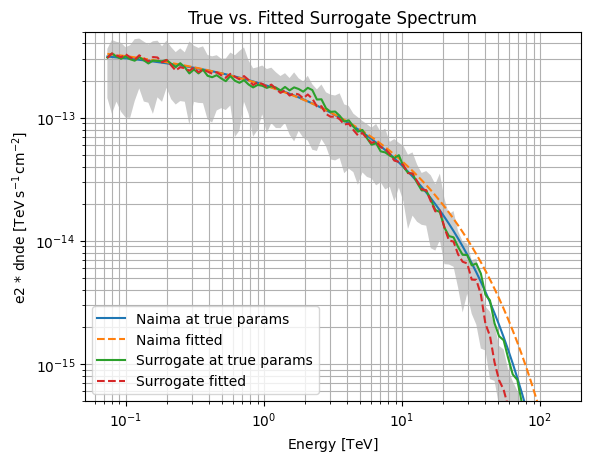

In [27]:
plt.figure()
energy_bounds = [E_true[0], E_true[-1]]
opts = dict(energy_bounds=energy_bounds, energy_power=2)  # SED-style plot
ax = true_spec.plot(label="Naima at true params", **opts)  
ax = naima_spec.plot(label="Naima fitted", ls="--", **opts)  
sur_true.plot(label="Surrogate at true params", **opts)          
fit_source.spectral_model.plot(ax=ax, label="Surrogate fitted", ls="--", **opts)                      
fit_source.spectral_model.plot_error(ax=ax, **opts)
#naima_spec.plot_error(ax=ax, **opts) #much slower because not vectorized

ax.set_title("True vs. Fitted Surrogate Spectrum")
ax.grid(True, which="both")
ax.legend()
ax.set_ylim([5e-16, 5e-13])
plt.show()



## Compare performaces


In [28]:
def time_spectral(model, E, n_rep=1000):
    _ = model(E)
    t0 = time.perf_counter()
    acc = 0.0
    for _ in range(n_rep):
        y = model(E)                 # Quantity
        acc += float(np.asarray(y.value).sum())  # prevents dead-code elimination
    t1 = time.perf_counter()
    return (t1 - t0) / n_rep, acc

N_REP_TRUE = 200     # true model is slower; use fewer reps to keep runtime reasonable
N_REP_SUR  = 200    # surrogate is fast; use more reps for stable stats

t_true, _ = time_spectral(naima_spec, E_true, n_rep=N_REP_TRUE)
t_sur , _ = time_spectral(sur_spec , E_true, n_rep=N_REP_SUR)

print("=== Spectral evaluation timing ===")
print(f"True NaimaSpectralModel : {t_true*1e3:8.3f} ms / call  (n={N_REP_TRUE})")
print(f"Surrogate model         : {t_sur *1e3:8.3f} ms / call  (n={N_REP_SUR})")
print(f"Speed-up (true/surrogate): {t_true / t_sur:8.1f} ×")


=== Spectral evaluation timing ===
True NaimaSpectralModel :    4.107 ms / call  (n=200)
Surrogate model         :    1.065 ms / call  (n=200)
Speed-up (true/surrogate):      3.9 ×
